# Read in the data

In [2]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
survey_fields = survey_fields[1:]


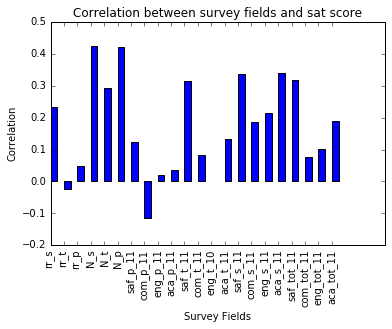

In [12]:
fig, ax = plt.subplots()
ax.bar(range(len(survey_fields)), correlations[survey_fields], 0.5)

ax.set_xticks(range(len(survey_fields)))
ax.set_xticklabels(survey_fields, rotation=90)
plt.title("Correlation between survey fields and sat score")
plt.xlabel("Survey Fields")
plt.ylabel("Correlation")

plt.show()


According to analysis of the correlation between survey fields and sat scores at NYC high schools, sat scores have a significant positive correlation associated with the following fields (Number of student respondents, Number of teacher respondents, Number of parent respondents, Safety and respect score based on teacher responses, Safety and respect score based on student responses, Academic expectations score based on student responses, and Safety and respect score total).
The number of responses from parents, students, and teachers seem to underlie the fact that larger schools seem to have higher sat scores, as the response rates of the teachers and parents remained similar across different schools.
The safety and respect score seems to point towards an environment of stable conditions where studying is encouraged.

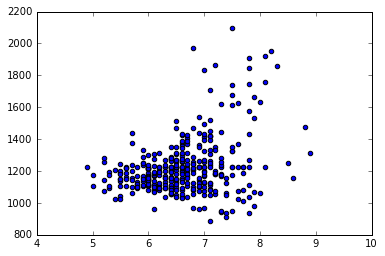

In [13]:
plt.scatter(combined['saf_s_11'], combined['sat_score'])

A plot of Safety and Respect (SAR) scores vs SAT Scores indicates there is a positive correlation. Most schools have low SAR and low SAT score, whereas a few outliers have higher SAR and higher SAT score. 

In [16]:
combined_by_dist = combined.groupby('school_dist')
districts = combined_by_dist.agg(numpy.mean)

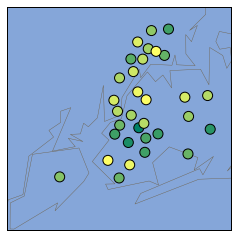

In [17]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
   projection='merc',
   llcrnrlat=40.496044,
   urcrnrlat=40.915256,
   llcrnrlon=-74.255735,
   urcrnrlon=-73.700272,
   resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s= 100, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')


plt.show()


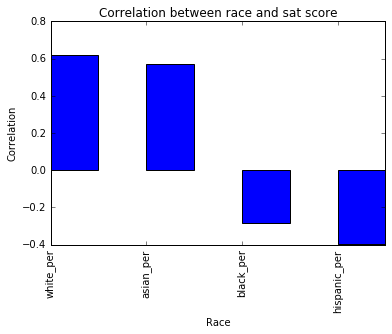

In [18]:
fig, ax = plt.subplots()
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
ax.bar(range(len(races)), correlations[races], 0.5)

ax.set_xticks(range(len(races)))
ax.set_xticklabels(races, rotation=90)
plt.title("Correlation between race and sat score")
plt.xlabel("Race")
plt.ylabel("Correlation")

plt.show()


The above plot shows that there is strong correlation between race and SAT scores. SAT scores are positively correlated with percentage of white and asian populations and negatively correlated with percentage of black and hispanic populations.

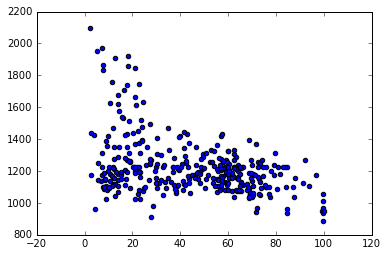

In [19]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])

The above plot shows that while there is an abundance of schools with low SAT scores regardless of the percentage of hispanic students, there are a number of schools with high SAT scores and low hispanic population. Also, the schools with the highest hispanic population have low SAT scores.

In [25]:
combined.loc[(combined['hispanic_per'] > 95),['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


Many of the schools with hispanic percentage greater than 95% tend to be servicing newly arrived immigrants from Dominican Republic, and other Spanish speaking countries, leading to low English proficiency levels. These schools are small, 300 - 500 students, and a good majority of them are from economically disadvantaged backgrounds.

In [27]:
combined.loc[((combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)), ['SCHOOL NAME', 'hispanic_per']]

,SCHOOL NAME,hispanic_per
37,STUYVESANT HIGH SCHOOL,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3


Number one, all of the high schools with hispanic percentage of less than 10% and SAT scores greater than 1800 have Wikipedia pages. All of these schools are a form of magnet/test required schools. They have high graduation rates. These schools tend to be big (all but one 1000+ and some 5000+). Some of these schools have been established in the early 1900s.

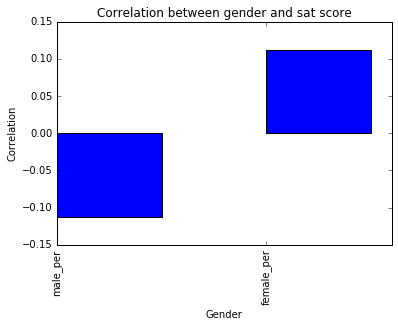

In [29]:
fig, ax = plt.subplots()
gender = ["male_per", "female_per"]
ax.bar(range(len(gender)), correlations[gender], 0.5)

ax.set_xticks(range(len(gender)))
ax.set_xticklabels(gender, rotation=90)
plt.title("Correlation between gender and sat score")
plt.xlabel("Gender")
plt.ylabel("Correlation")

plt.show()

Although it is not very significant, there is a negative correlation between male percentage of population and SAT score. Equally not significant, there is a positive correlation between female percentage of population and SAT score.

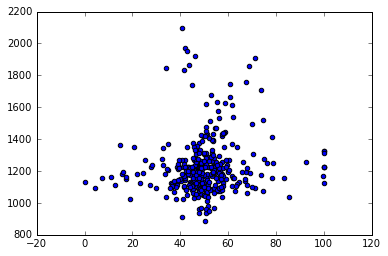

In [31]:
plt.scatter(combined['female_per'], combined['sat_score'])

There is a concentration of schools with even male and female percentages that have low SAT scores. A few outliers with low female or high female percentages also have low SAT scores.

In [33]:
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700),['SCHOOL NAME', 'female_per', 'sat_score']]

,SCHOOL NAME,female_per,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0


These schools with female percentage greater than 60% and average SAT score greater than 1700 are all magnet schools with student body size greater than 1000.

In [39]:
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) 

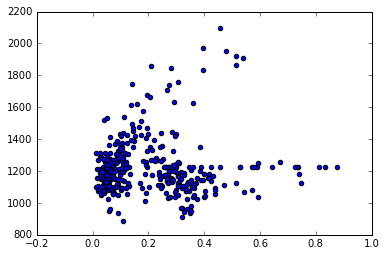

In [40]:
plt.scatter(combined['ap_per'], combined['sat_score'])

In [41]:
combined[['ap_per', 'sat_score']].corr()

,ap_per,sat_score
ap_per,1.000000,0.057171
sat_score,0.057171,1.000000


From the plot, there seems to be a group of schools that have a correlation between AP test taker percentage and SAT score, but another group of schools that have a constant SAT score regardless of AP test taker percentage.